In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import scipy.io as sio
from scipy.interpolate import griddata
import copy
from matplotlib.pyplot import figure
from termcolor import colored


---
# VIDEO: Outliers via standard deviation threshold
---


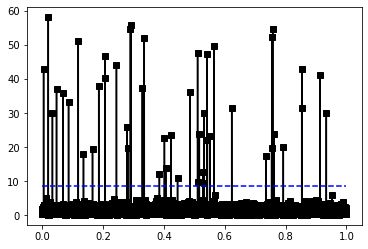

In [94]:
## signal is log-normal noise
N = 10000
time = np.arange(0,N)/N
signal1 = np.exp( .5*np.random.randn(N) )

# add some random outiers
nOutliers = 50
randpnts = np.random.randint(0,N,nOutliers)
signal1[randpnts] = np.random.rand(nOutliers) * (np.max(signal1)-np.min(signal1))*10

# show the signal
plt.plot(time,signal1,'ks-')

# auto-threshold based on mean and standard deviation
threshold = np.mean(signal1) + 3*np.std(signal1)
plt.plot([time[0],time[-1]],[threshold,threshold],'b--')
plt.show()

46
[0.000e+00 1.000e-04 2.000e-04 ... 9.997e-01 9.998e-01 9.999e-01]
[1.99776275 0.94532683 1.34571441 ... 0.44365913 1.4438803  1.10995653]


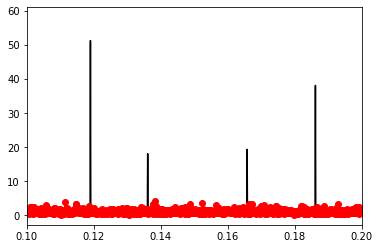

In [95]:
## interpolate outlier points


# remove supra-threshold points
outliers = signal1 > threshold
print(sum(outliers))
print(time[~outliers])
print(signal1[~outliers])
# and interpolate missing points
signalR = copy.deepcopy( signal1 )
signalR[outliers] = griddata(time[~outliers], signal1[~outliers], time[outliers], method='cubic')

# and plot the new results
plt.plot(time,signal1,'k-')
plt.plot(time,signalR,'ro-')

## optional zoom
plt.xlim([.1,.2])

plt.show()



---
# VIDEO: Outliers via local threshold exceedance
---


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


(371635, 7)
              2        3        4        5
1280    1.04860  1.04885  1.04859  1.04882
2719    1.04030  1.04032  1.04023  1.04025
4159    1.05276  1.05276  1.05253  1.05261
5599    1.05817  1.05817  1.05803  1.05803
6618    1.05301  1.05308  1.05290  1.05306
...         ...      ...      ...      ...
366334  1.18694  1.18699  1.18694  1.18697
367750  1.18743  1.18752  1.18743  1.18745
369187  1.19175  1.19176  1.19173  1.19173
370619  1.19443  1.19443  1.19443  1.19443
371634  1.19982  1.20074  1.19980  1.20005

[310 rows x 4 columns]
[1.0486  1.04885 1.04859 ... 1.20074 1.1998  1.20005]


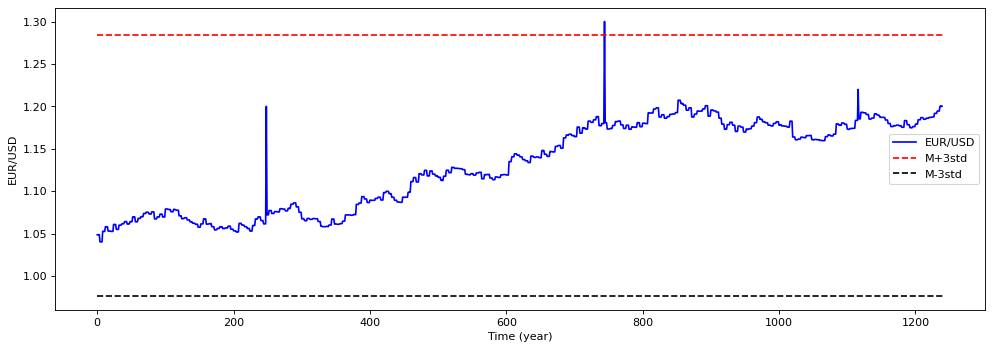

In [96]:
# data downloaded from:
# http://www.histdata.com/download-free-forex-historical-data/?/ascii/1-minute-bar-quotes/eurusd/2017

df = pd.read_csv("DAT_ASCII_EURUSD_M1_2017.csv", sep=' |;', header = None)
print(df.shape)
# drop duplicated day for simplify computation
df = df.drop_duplicates(subset=0, keep="last")
df = df.drop(0, axis=1)
df = df.drop(1, axis=1)
df = df.drop(6, axis=1)
print(df)

forex = df.to_numpy().flatten()
print(forex)

# import data, etc.
#matdat = sio.loadmat('forex.mat')
#forex  = np.squeeze(matdat['forex'])

N = len(forex)
time = np.arange(0,N)/N


# add some outliner
forex[round(0.2/1 * N)] = 1.2
forex[round(0.6/1 * N)] = 1.3
forex[round(0.9/1 * N)] = 1.22

# plot it
figure(figsize=(15, 5), dpi=80)
#plt.plot(time,forex)
plt.xlabel('Time (year)')
plt.ylabel('EUR/USD')

# add global thresholds
threshup = np.mean(forex)+3*np.std(forex)
threshdn = np.mean(forex)-3*np.std(forex)
plt.plot(range(0,N),forex,'b',label='EUR/USD')
plt.plot([0,N],[threshup,threshup],'r--',label='M+3std')
plt.plot([0,N],[threshdn,threshdn],'k--',label='M-3std')
plt.legend()
plt.show()

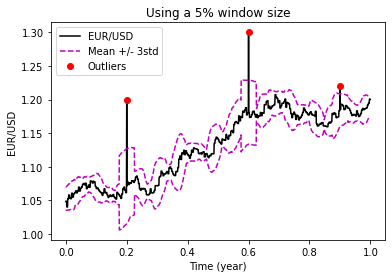

In [97]:
## local threshold

# window size as percent of total signal length
pct_win = 5 # in percent, not proportion!

# convert to indices
k = int(len(forex) * (pct_win/2/100))

# # initialize statistics time series to be the global stats
mean_ts = np.ones(len(time)) * np.mean(forex)
std3_ts = np.ones(len(time)) * np.std(forex)


# # loop over time points
for i in range(0,N):
    
     # boundaries
     lo_bnd = np.max((0,i-k))
     hi_bnd = np.min((i+k,N))
    
     # compute local mean and std
     mean_ts[i] =  np.mean( forex[range(lo_bnd,hi_bnd)] )
     std3_ts[i] = 3*np.std( forex[range(lo_bnd,hi_bnd)] )


## compute local outliers 
outliers = (forex > mean_ts+std3_ts) | (forex < mean_ts-std3_ts)


# plotting...
plt.plot(time,forex,'k',label='EUR/USD')
plt.plot(time,mean_ts+std3_ts,'m--',label='Mean +/- 3std')
plt.plot(time,mean_ts-std3_ts,'m--')

# and plot those
plt.plot(time[outliers],forex[outliers],'ro',label='Outliers')

plt.legend()
plt.xlabel('Time (year)')
plt.ylabel('EUR/USD')
plt.title('Using a %d%% window size' %pct_win)
plt.show()


---
# VIDEO: Outlier time windows via sliding RMS
---


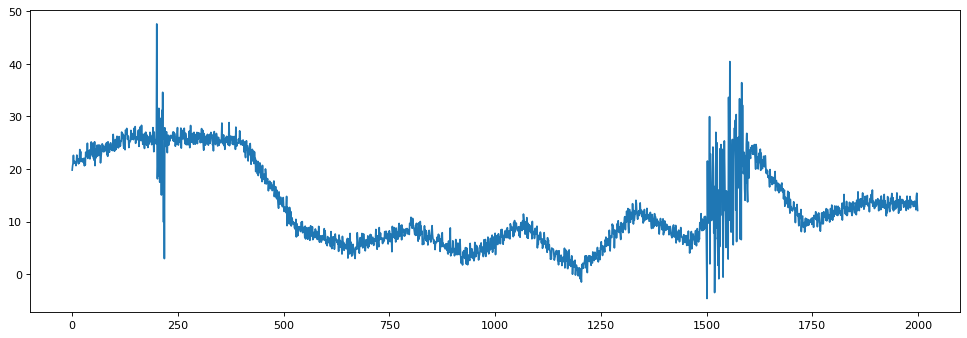

In [98]:
## generate signal with varying variability
n = 2000
p = 15  # poles for random interpolation

# amplitude modulator
signal1 = np.interp(np.linspace(0,p,n),np.arange(0,p),np.random.rand(p)*30)
signal1 = signal1 + np.random.randn(n)


# add some high-amplitude noise
signal1[200:221]   = signal1[200:221] + np.random.randn(21)*9
signal1[1500:1601] = signal1[1500:1601] + np.random.randn(101)*9


# plot
figure(figsize=(15, 5), dpi=80)
plt.plot(signal1)
plt.show()


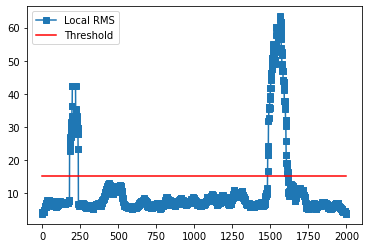

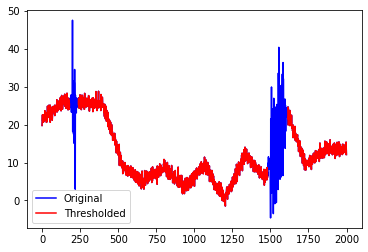

In [99]:
## detect bad segments using sliding RMS

# window size as percent of total signal length
pct_win = 2  # in percent, not proportion!

# convert to indices
k = int(n * (pct_win/2/100))

# initialize RMS time series vector
rms_ts = np.zeros(n)

for ti in range(0,n):
    
    # boundary points
    low_bnd = int( np.max((0,ti-k)) )
    upp_bnd = int( np.min((n,ti+k)) )
    
    # signal segment (and mean-center!)
    tmpsig = signal1[range(low_bnd,upp_bnd)]
    tmpsig = tmpsig - np.mean(tmpsig)
    
    # compute RMS in this window
    rms_ts[ti] = np.sqrt(np.sum( tmpsig**2 ))



# plot RMS
plt.plot(rms_ts,'s-',label='Local RMS')


# pick threshold manually based on visual inspection
thresh = 15
plt.plot([0,n],[thresh,thresh],'r',label='Threshold')
plt.legend()
plt.show()



# mark bad regions in original time series
signalR = copy.deepcopy( signal1 )
signalR[ rms_ts>thresh ] = np.nan


plt.plot(signal1,'b',label='Original')
plt.plot(signalR,'r',label='Thresholded')
plt.legend()
plt.show()